
# Deep Learning Project - Art Movement classification

*   António Pinto
*   Davide Farinati
*   Tomás Sá

Dataset: Pandora 7k Variantion (10 classes)

Execution environment: Google Colab

# Packages imports

In [ ]:
import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, CSVLogger
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import os, shutil, cv2
import seaborn as sns
import numpy as np
import pandas as pd
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

Authorize google drive’s access through execution environment 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data extraction & organization

Download zip file with data from the url and extract it to our working directory

In [ ]:
datasetURL = 'http://imag.pub.ro/pandora/Download/Pandora_V1.zip'
myDir = r'/content/drive/MyDrive/deepLearning/project_data_V1'

# If data is not available yet, downloads and extracts it from the url
if not os.path.exists(myDir):
  with urlopen(datasetURL) as zipresp:
      with ZipFile(BytesIO(zipresp.read())) as zfile:
          zfile.extractall(myDir)

Data from the zipfile is divided in folders with each art movement. Next, we reorganize the data to have the desirable structure:

train/

... art movements...

validation/

... art movements...

test/

... art movements...

In [ ]:
if not os.path.exists(myDir+r'/train'):
  bad_list=[]
  subdir_list=os.listdir(myDir) # create a list of the sub directories in the directory ie train or test
  for d in subdir_list:  # iterate through the sub directories train and test
      dpath=os.path.join(myDir, d) # create path to sub directory
      if d in ['val']:
          class_list=os.listdir(dpath) # list of classes ie realism
          for klass in class_list: # iterate through classes
              class_path=os.path.join(dpath, klass) # path to class directory
              file_list=os.listdir(class_path) # create list of files in class directory
              for f in file_list: # iterate through the files
                  fpath=os.path.join (class_path,f)
                  index=f.rfind('.') # find index of period infilename
                  ext=f[index+1:] # get the files extension
                  if ext  not in ['jpg', 'png', 'bmp', 'gif']:
                      bad_list.append(fpath)                    
                  else:
                      try:
                          img=cv2.imread(fpath)
                          size=img.shape
                      except:
                          print(f'file {fpath} is not a valid image file ')
                          bad_list.append(fpath)
                        
  for file_ in bad_list:
    os.remove(file_)        

# Settings

In [ ]:
patience = 12
size = 256
seed = 5

# Data pre processing


Creating the tensors with the dataset to be fed to the CNN. While the dataset is being pre-processed, the tensor image is subjected to a technique of data augmentation, where several transformations are applied to the images on the training set.

In [ ]:
#Augmentation
train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                    myDir+r'/train',
                    target_size = (size, size),
                    batch_size = 32,
                    class_mode = 'categorical',
                    seed = seed)

validation_generator = val_datagen.flow_from_directory(
                    myDir+r'/val',
                    target_size = (size, size),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = False,
                    seed = seed)

test_data_generator = test_generator.flow_from_directory(
                     myDir+r'/test', 
                     target_size=(size, size),
                     batch_size=32,
                     shuffle=False,
                     seed = seed)

Found 5314 images belonging to 10 classes.
Found 1269 images belonging to 10 classes.
Found 34 images belonging to 10 classes.


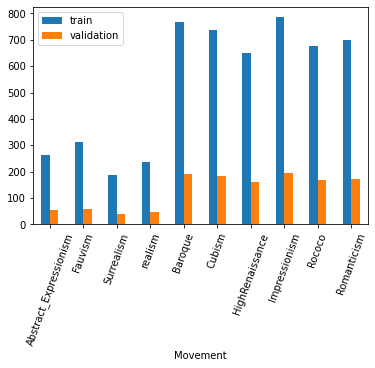

In [ ]:
columns = os.listdir(myDir+r'/train')

imageClass = pd.DataFrame(columns=['Movement', 'train', 'validation'])

for i in range(len(columns)):
    train = len([name for name in os.listdir(myDir+'/train/'+columns[i])])
    val = len([name for name in os.listdir(myDir+'/val/'+columns[i])])
    imageClass = imageClass.append({'Movement': columns[i], 'train': train, 'validation': val}, ignore_index=True)
  
imageClass.plot(x="Movement", y=["train", "validation"], kind="bar", rot=70)

# Functions

These functions will be assess models’ performance

In [ ]:
def plot_train_val_loss(history_dict, epochs):
    ''' Plots the training and validation loss over the epochs'''
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = epochs

    plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:
def plot_train_val_acc(history_dict, epochs):
    ''' Plots the training and validation accuracy over the epochs'''
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    
    epochs = epochs
    
    plt.plot(epochs, acc_values, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc_values, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
def confusion_matrix_report(model, test = test_data_generator):
  '''Plots a confusion matrix with the classes each image belongs to and the predicted ones'''
  test_steps_per_epoch = numpy.math.ceil(test.samples / test.batch_size)
  predictions = model.predict(test, steps=test_steps_per_epoch)
  predicted_classes = numpy.argmax(predictions, axis=1)
  true_classes = test.classes
  class_labels = list(test.class_indices.keys())
  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cf = metrics.confusion_matrix(true_classes, predicted_classes)
  sns.heatmap(cf, annot=True, xticklabels=class_labels, yticklabels=class_labels)
  plt.show()
  print(report)

# 1st model



In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(50, (3,3), activation = 'relu', input_shape=(size, size, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(100, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 254, 254, 50)      1400      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 127, 127, 50)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 125, 125, 100)     45100     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 62, 62, 100)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 384400)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 384400)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights=True)
csv_logger = CSVLogger(myDir+'/modelsLogger/1st_Model.csv')

history = model.fit(train_generator, 
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, csv_logger])

Epoch 1/100
167/167 [==============================] - 116s 693ms/step - loss: 3.2069 - accuracy: 0.0948 - val_loss: 2.1336 - val_accuracy: 0.2096
Epoch 2/100
167/167 [==============================] - 115s 689ms/step - loss: 2.0863 - accuracy: 0.2668 - val_loss: 1.9703 - val_accuracy: 0.2703
Epoch 3/100
167/167 [==============================] - 115s 687ms/step - loss: 1.9228 - accuracy: 0.2860 - val_loss: 1.8377 - val_accuracy: 0.3050
Epoch 4/100
167/167 [==============================] - 115s 686ms/step - loss: 1.8398 - accuracy: 0.3042 - val_loss: 1.8063 - val_accuracy: 0.3136
Epoch 5/100
167/167 [==============================] - 115s 686ms/step - loss: 1.7932 - accuracy: 0.3149 - val_loss: 1.9216 - val_accuracy: 0.2703
Epoch 6/100
167/167 [==============================] - 115s 686ms/step - loss: 1.7547 - accuracy: 0.3353 - val_loss: 1.7850 - val_accuracy: 0.3073
Epoch 7/100
167/167 [==============================] - 115s 686ms/step - loss: 1.7190 - accuracy: 0.3489 - val_loss: 1

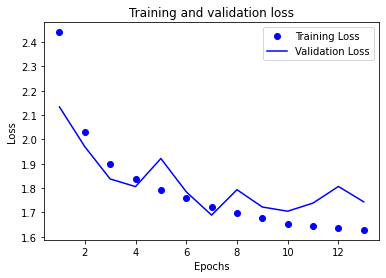

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

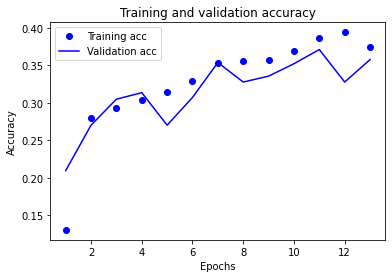

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


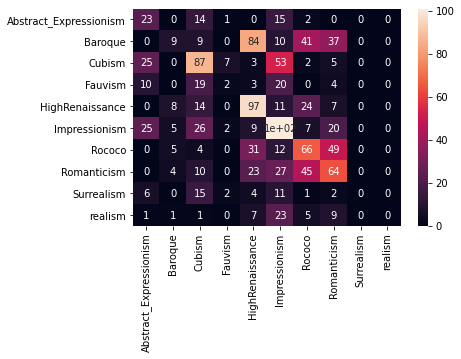

                        precision    recall  f1-score   support

Abstract_Expressionism       0.26      0.42      0.32        55
               Baroque       0.28      0.05      0.08       190
                Cubism       0.44      0.48      0.46       182
               Fauvism       0.14      0.03      0.06        58
       HighRenaissance       0.37      0.60      0.46       161
         Impressionism       0.36      0.52      0.42       195
                Rococo       0.34      0.40      0.37       167
           Romanticism       0.32      0.37      0.35       173
            Surrealism       0.00      0.00      0.00        41
               realism       0.00      0.00      0.00        47

              accuracy                           0.35      1269
             macro avg       0.25      0.29      0.25      1269
          weighted avg       0.31      0.35      0.31      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


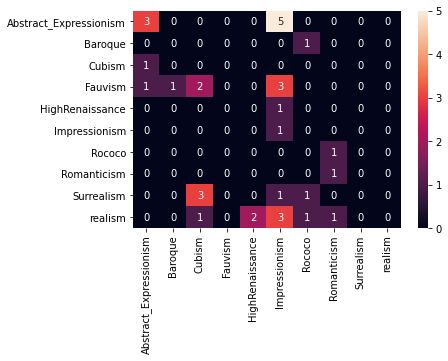

                        precision    recall  f1-score   support

Abstract_Expressionism       0.60      0.38      0.46         8
               Baroque       0.00      0.00      0.00         1
                Cubism       0.00      0.00      0.00         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.00      0.00      0.00         1
         Impressionism       0.07      1.00      0.13         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.33      1.00      0.50         1
            Surrealism       0.00      0.00      0.00         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.15        34
             macro avg       0.10      0.24      0.11        34
          weighted avg       0.15      0.15      0.13        34



In [ ]:
confusion_matrix_report(model)

In [ ]:
model.save(myDir+'/models/1st_Model.h5')

# Best model



In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 256)      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights=True)
csv_logger = CSVLogger(myDir+'/modelsLogger/bestModel.csv')

history = model.fit(train_generator, epochs=100,
                              validation_data=validation_generator,
                            callbacks=[early_stopping, csv_logger])

Epoch 1/100
167/167 [==============================] - 124s 733ms/step - loss: 2.2220 - accuracy: 0.1904 - val_loss: 1.8662 - val_accuracy: 0.2987
Epoch 2/100
167/167 [==============================] - 121s 724ms/step - loss: 1.8524 - accuracy: 0.2976 - val_loss: 1.9181 - val_accuracy: 0.3050
Epoch 3/100
167/167 [==============================] - 121s 726ms/step - loss: 1.7665 - accuracy: 0.3180 - val_loss: 1.7592 - val_accuracy: 0.3239
Epoch 4/100
167/167 [==============================] - 122s 730ms/step - loss: 1.7428 - accuracy: 0.3242 - val_loss: 1.6600 - val_accuracy: 0.3704
Epoch 5/100
167/167 [==============================] - 122s 730ms/step - loss: 1.6585 - accuracy: 0.3672 - val_loss: 1.7046 - val_accuracy: 0.3499
Epoch 6/100
167/167 [==============================] - 121s 725ms/step - loss: 1.6499 - accuracy: 0.3701 - val_loss: 1.6319 - val_accuracy: 0.3853
Epoch 7/100
167/167 [==============================] - 123s 736ms/step - loss: 1.6092 - accuracy: 0.3799 - val_loss: 1

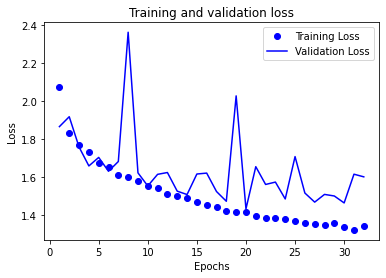

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

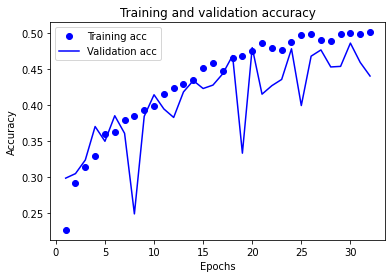

In [ ]:
plot_train_val_acc(history_dict, epochs)

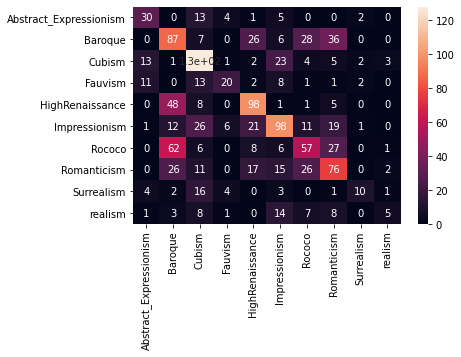

                        precision    recall  f1-score   support

Abstract_Expressionism       0.50      0.55      0.52        55
               Baroque       0.36      0.46      0.40       190
                Cubism       0.54      0.70      0.61       182
               Fauvism       0.56      0.34      0.43        58
       HighRenaissance       0.56      0.61      0.58       161
         Impressionism       0.55      0.50      0.52       195
                Rococo       0.42      0.34      0.38       167
           Romanticism       0.43      0.44      0.43       173
            Surrealism       0.59      0.24      0.34        41
               realism       0.42      0.11      0.17        47

              accuracy                           0.48      1269
             macro avg       0.49      0.43      0.44      1269
          weighted avg       0.48      0.48      0.47      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


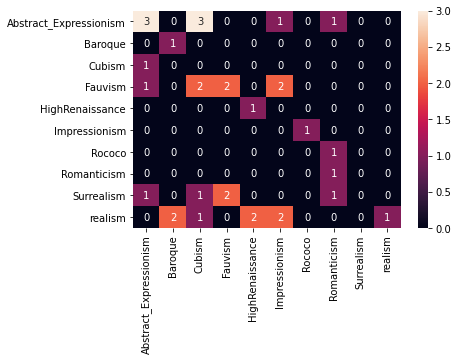

                        precision    recall  f1-score   support

Abstract_Expressionism       0.50      0.38      0.43         8
               Baroque       0.33      1.00      0.50         1
                Cubism       0.00      0.00      0.00         1
               Fauvism       0.50      0.29      0.36         7
       HighRenaissance       0.33      1.00      0.50         1
         Impressionism       0.00      0.00      0.00         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.25      1.00      0.40         1
            Surrealism       0.00      0.00      0.00         5
               realism       1.00      0.12      0.22         8

              accuracy                           0.26        34
             macro avg       0.29      0.38      0.24        34
          weighted avg       0.48      0.26      0.27        34



In [ ]:
confusion_matrix_report(model)

In [ ]:
model.save(myDir+'/models/bestModel.h5')

# Grid search - Best model



In [ ]:
def create_model(neur, droupout):
  model = models.Sequential()

  model.add(layers.Conv2D(neur, (3, 3), activation='relu', input_shape=(256, 256, 3)))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(neur*2, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(neur*2, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(neur*3, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))

  model.add(layers.Flatten())
  model.add(layers.Dropout(droupout))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

8
0
Epoch 1/30
167/167 [==============================] - 2475s 15s/step - loss: 2.1388 - accuracy: 0.1974 - val_loss: 1.9211 - val_accuracy: 0.2813
Epoch 2/30
167/167 [==============================] - 113s 678ms/step - loss: 1.7911 - accuracy: 0.3129 - val_loss: 1.8017 - val_accuracy: 0.3128
Epoch 3/30
167/167 [==============================] - 113s 678ms/step - loss: 1.7523 - accuracy: 0.3323 - val_loss: 1.8707 - val_accuracy: 0.3081
Epoch 4/30
167/167 [==============================] - 113s 678ms/step - loss: 1.7388 - accuracy: 0.3278 - val_loss: 2.0532 - val_accuracy: 0.2774
Epoch 5/30
167/167 [==============================] - 113s 677ms/step - loss: 1.7062 - accuracy: 0.3410 - val_loss: 1.7838 - val_accuracy: 0.3215
Epoch 6/30
167/167 [==============================] - 113s 678ms/step - loss: 1.6740 - accuracy: 0.3509 - val_loss: 1.7033 - val_accuracy: 0.3499
Epoch 7/30
167/167 [==============================] - 114s 684ms/step - loss: 1.6628 - accuracy: 0.3645 - val_loss: 1.667

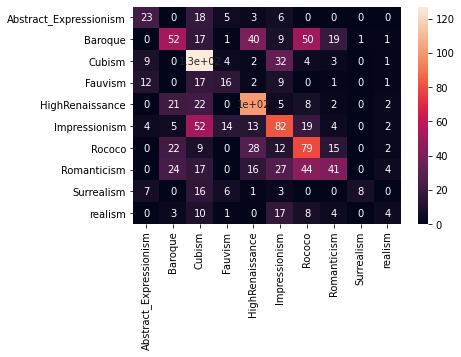

                        precision    recall  f1-score   support

Abstract_Expressionism       0.42      0.42      0.42        55
               Baroque       0.41      0.27      0.33       190
                Cubism       0.42      0.70      0.52       182
               Fauvism       0.34      0.28      0.30        58
       HighRenaissance       0.49      0.63      0.55       161
         Impressionism       0.41      0.42      0.41       195
                Rococo       0.37      0.47      0.42       167
           Romanticism       0.46      0.24      0.31       173
            Surrealism       0.89      0.20      0.32        41
               realism       0.24      0.09      0.12        47

              accuracy                           0.42      1269
             macro avg       0.44      0.37      0.37      1269
          weighted avg       0.43      0.42      0.40      1269

16
0
Epoch 1/30
167/167 [==============================] - 114s 677ms/step - loss: 2.1411 - accuracy:

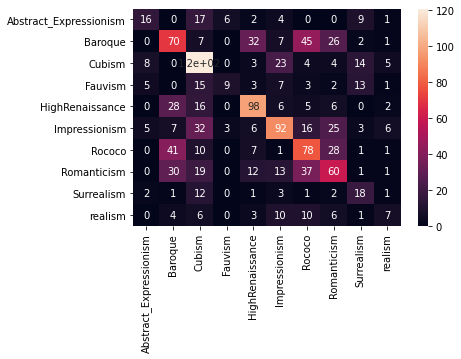

                        precision    recall  f1-score   support

Abstract_Expressionism       0.44      0.29      0.35        55
               Baroque       0.39      0.37      0.38       190
                Cubism       0.47      0.66      0.55       182
               Fauvism       0.50      0.16      0.24        58
       HighRenaissance       0.59      0.61      0.60       161
         Impressionism       0.55      0.47      0.51       195
                Rococo       0.39      0.47      0.43       167
           Romanticism       0.38      0.35      0.36       173
            Surrealism       0.29      0.44      0.35        41
               realism       0.27      0.15      0.19        47

              accuracy                           0.45      1269
             macro avg       0.43      0.40      0.40      1269
          weighted avg       0.45      0.45      0.44      1269

8
0.5
Epoch 1/30
167/167 [==============================] - 113s 671ms/step - loss: 2.1731 - accuracy

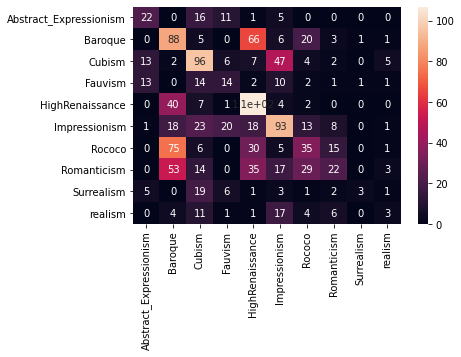

                        precision    recall  f1-score   support

Abstract_Expressionism       0.41      0.40      0.40        55
               Baroque       0.31      0.46      0.37       190
                Cubism       0.45      0.53      0.49       182
               Fauvism       0.24      0.24      0.24        58
       HighRenaissance       0.40      0.66      0.50       161
         Impressionism       0.45      0.48      0.46       195
                Rococo       0.32      0.21      0.25       167
           Romanticism       0.37      0.13      0.19       173
            Surrealism       0.60      0.07      0.13        41
               realism       0.19      0.06      0.10        47

              accuracy                           0.38      1269
             macro avg       0.37      0.32      0.31      1269
          weighted avg       0.38      0.38      0.36      1269

16
0.5
Epoch 1/30
167/167 [==============================] - 113s 671ms/step - loss: 2.1450 - accurac

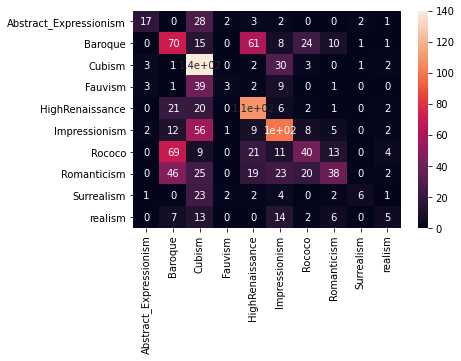

                        precision    recall  f1-score   support

Abstract_Expressionism       0.65      0.31      0.42        55
               Baroque       0.31      0.37      0.34       190
                Cubism       0.38      0.77      0.51       182
               Fauvism       0.38      0.05      0.09        58
       HighRenaissance       0.48      0.68      0.56       161
         Impressionism       0.48      0.51      0.50       195
                Rococo       0.40      0.24      0.30       167
           Romanticism       0.50      0.22      0.31       173
            Surrealism       0.60      0.15      0.24        41
               realism       0.25      0.11      0.15        47

              accuracy                           0.42      1269
             macro avg       0.44      0.34      0.34      1269
          weighted avg       0.43      0.42      0.39      1269



In [ ]:
params = {
    'neur': [8,16],
    'dropout': [0, 0.5]

}

param_grid = list(ParameterGrid(params))
gridModels = pd.DataFrame(columns=['Name', 'neur', 'dropout'])

for p in range(len(param_grid)):
  modelName = 'gridModel'+str(p)
  print(param_grid[p]['neur'])
  print(param_grid[p]['dropout'])
  model = create_model(param_grid[p]['neur'], param_grid[p]['dropout'])

  early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience/2, restore_best_weights=True)
  csv_logger = CSVLogger(myDir+'/modelsLogger/'+modelName+'.csv')

  gridModels = gridModels.append({'Name': modelName, 'neur': param_grid[p]['neur'], 'dropout': param_grid[p]['dropout']}, ignore_index=True)

  history = model.fit(train_generator, epochs=30,
                      validation_data=validation_generator,
                      callbacks=[early_stopping, csv_logger])
  
  confusion_matrix_report(model, test = validation_generator)
  model.save(myDir+'/models/'+modelName+'.h5')

gridModels.to_csv(myDir+'/models/gridModelsConf')

# Training set balanced



In [ ]:
if not os.path.exists(myDir+r'/train_bal'):
  os.mkdir(os.path.join('drive', 'MyDrive','project_data_V1','train_bal'))

  for genre in os.listdir(os.path.join('drive', 'MyDrive','project_data_V1','train')):

    os.mkdir(os.path.join('drive', 'MyDrive','project_data_V1','train_bal', genre))
    paintings = os.listdir(os.path.join('drive', 'MyDrive','project_data_V1','train', genre))

    for painting in paintings[:189]:

      src = os.path.join('drive', 'MyDrive','project_data_V1','train', genre, painting)
      dst = os.path.join('drive', 'MyDrive','project_data_V1','train_bal', genre, painting)
      shutil.copyfile(src, dst)

In [ ]:
#Augmentation
train_bal_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

train_bal_generator = train_bal_datagen.flow_from_directory(
                    myDir+r'/train_bal',
                    target_size = (size, size),
                    batch_size = 32,
                    class_mode = 'categorical',
                    seed = seed)

Found 1890 images belonging to 10 classes.


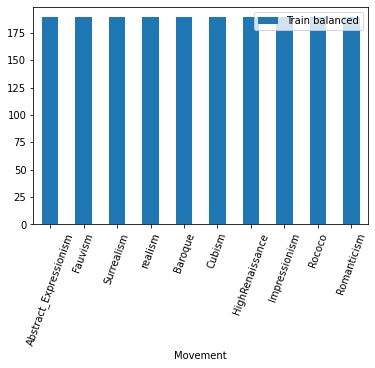

In [ ]:
columns = os.listdir(myDir+r'/train_bal')

imageClass = pd.DataFrame(columns=['Movement', 'Train balanced'])

for i in range(len(columns)):
    train = len([name for name in os.listdir(myDir+'/train_bal/'+columns[i])])
    imageClass = imageClass.append({'Movement': columns[i], 'Train balanced': train}, ignore_index=True)
  
imageClass.plot(x="Movement", y=["Train balanced"], kind="bar", rot=70)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 256)      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 12, restore_best_weights=True)
csv_logger = CSVLogger(myDir+'/modelsLogger/balancedBestModel.csv')

history = model.fit(train_bal_generator, epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, csv_logger])

Epoch 1/100
60/60 [==============================] - 518s 9s/step - loss: 2.7736 - accuracy: 0.1143 - val_loss: 2.2286 - val_accuracy: 0.1418
Epoch 2/100
60/60 [==============================] - 53s 883ms/step - loss: 2.1990 - accuracy: 0.1899 - val_loss: 2.7457 - val_accuracy: 0.0993
Epoch 3/100
60/60 [==============================] - 53s 890ms/step - loss: 2.0147 - accuracy: 0.2271 - val_loss: 1.9977 - val_accuracy: 0.1812
Epoch 4/100
60/60 [==============================] - 53s 883ms/step - loss: 1.9407 - accuracy: 0.2523 - val_loss: 2.2733 - val_accuracy: 0.1639
Epoch 5/100
60/60 [==============================] - 53s 885ms/step - loss: 1.9472 - accuracy: 0.2591 - val_loss: 1.8560 - val_accuracy: 0.2955
Epoch 6/100
60/60 [==============================] - 53s 877ms/step - loss: 1.8911 - accuracy: 0.2994 - val_loss: 1.9076 - val_accuracy: 0.2695
Epoch 7/100
60/60 [==============================] - 53s 884ms/step - loss: 1.8043 - accuracy: 0.3287 - val_loss: 1.8475 - val_accuracy: 0

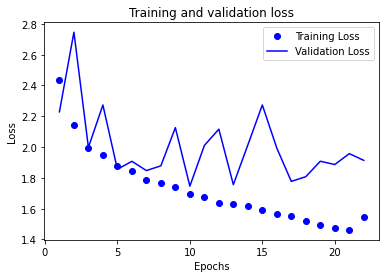

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

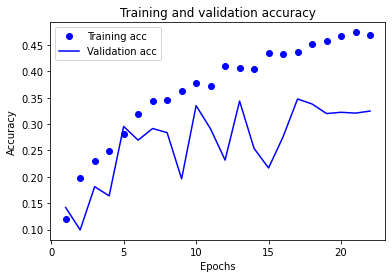

In [ ]:
plot_train_val_acc(history_dict, epochs)

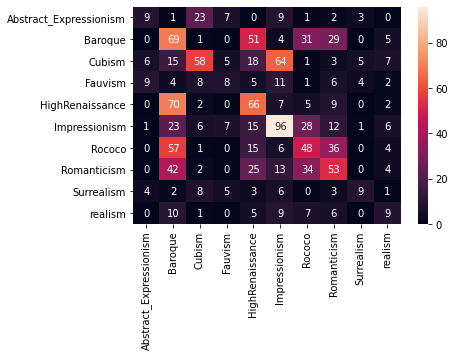

                        precision    recall  f1-score   support

Abstract_Expressionism       0.31      0.16      0.21        55
               Baroque       0.24      0.36      0.29       190
                Cubism       0.53      0.32      0.40       182
               Fauvism       0.25      0.14      0.18        58
       HighRenaissance       0.33      0.41      0.36       161
         Impressionism       0.43      0.49      0.46       195
                Rococo       0.31      0.29      0.30       167
           Romanticism       0.33      0.31      0.32       173
            Surrealism       0.41      0.22      0.29        41
               realism       0.23      0.19      0.21        47

              accuracy                           0.33      1269
             macro avg       0.34      0.29      0.30      1269
          weighted avg       0.35      0.33      0.33      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

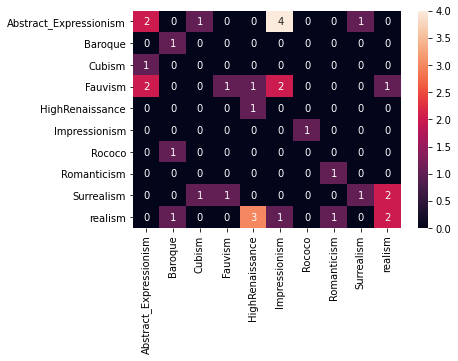

                        precision    recall  f1-score   support

Abstract_Expressionism       0.40      0.25      0.31         8
               Baroque       0.33      1.00      0.50         1
                Cubism       0.00      0.00      0.00         1
               Fauvism       0.50      0.14      0.22         7
       HighRenaissance       0.20      1.00      0.33         1
         Impressionism       0.00      0.00      0.00         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.50      1.00      0.67         1
            Surrealism       0.50      0.20      0.29         5
               realism       0.40      0.25      0.31         8

              accuracy                           0.26        34
             macro avg       0.28      0.38      0.26        34
          weighted avg       0.40      0.26      0.28        34



In [ ]:
confusion_matrix_report(model)

In [ ]:
model.save(myDir+'/models/bestModelBalances.h5')

# VGG19



In [ ]:
from keras.applications import VGG19

model = models.Sequential()

model.add(VGG19(weights = 'imagenet', include_top = False, input_shape = (size, size, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.layers[0].trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               4194432   
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1290      
Total params: 24,220,106
Trainable params: 4,195,722
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 12, restore_best_weights=True)
csv_logger = CSVLogger(myDir+'/modelsLogger/vgg19.csv')

history = model.fit(train_generator, epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, csv_logger])

Epoch 1/100
167/167 [==============================] - 141s 797ms/step - loss: 5.2836 - accuracy: 0.2042 - val_loss: 1.8412 - val_accuracy: 0.3207
Epoch 2/100
167/167 [==============================] - 129s 770ms/step - loss: 1.8697 - accuracy: 0.3161 - val_loss: 1.8744 - val_accuracy: 0.2955
Epoch 3/100
167/167 [==============================] - 128s 766ms/step - loss: 1.6791 - accuracy: 0.3804 - val_loss: 1.6807 - val_accuracy: 0.3554
Epoch 4/100
167/167 [==============================] - 128s 769ms/step - loss: 1.6629 - accuracy: 0.3792 - val_loss: 1.6642 - val_accuracy: 0.3649
Epoch 5/100
167/167 [==============================] - 128s 765ms/step - loss: 1.6104 - accuracy: 0.4008 - val_loss: 1.7782 - val_accuracy: 0.3562
Epoch 6/100
167/167 [==============================] - 128s 765ms/step - loss: 1.5601 - accuracy: 0.4025 - val_loss: 1.5645 - val_accuracy: 0.4027
Epoch 7/100
167/167 [==============================] - 128s 765ms/step - loss: 1.5117 - accuracy: 0.4241 - val_loss: 1

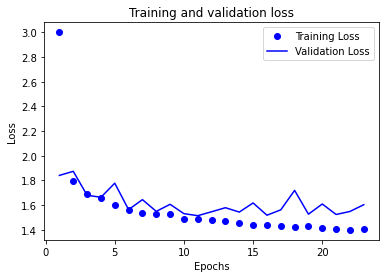

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

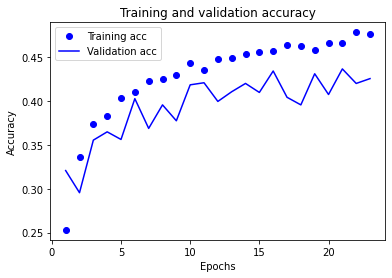

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


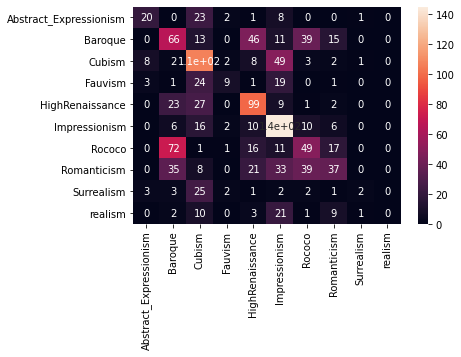

                        precision    recall  f1-score   support

Abstract_Expressionism       0.59      0.36      0.45        55
               Baroque       0.31      0.35      0.33       190
                Cubism       0.42      0.59      0.49       182
               Fauvism       0.50      0.16      0.24        58
       HighRenaissance       0.48      0.61      0.54       161
         Impressionism       0.47      0.74      0.58       195
                Rococo       0.34      0.29      0.32       167
           Romanticism       0.41      0.21      0.28       173
            Surrealism       0.40      0.05      0.09        41
               realism       0.00      0.00      0.00        47

              accuracy                           0.42      1269
             macro avg       0.39      0.34      0.33      1269
          weighted avg       0.40      0.42      0.39      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


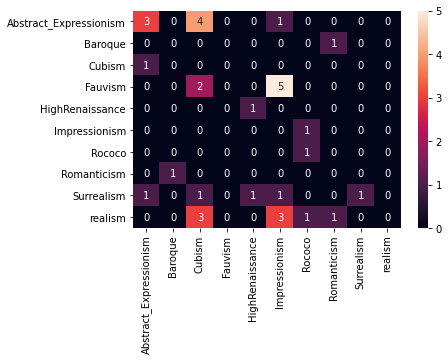

                        precision    recall  f1-score   support

Abstract_Expressionism       0.60      0.38      0.46         8
               Baroque       0.00      0.00      0.00         1
                Cubism       0.00      0.00      0.00         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.50      1.00      0.67         1
         Impressionism       0.00      0.00      0.00         1
                Rococo       0.33      1.00      0.50         1
           Romanticism       0.00      0.00      0.00         1
            Surrealism       1.00      0.20      0.33         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.18        34
             macro avg       0.24      0.26      0.20        34
          weighted avg       0.31      0.18      0.19        34



In [ ]:
confusion_matrix_report(model)

In [ ]:
model.save(myDir+'/models/vgg19.h5')

# Plotting results

In [ ]:
filesData = os.listdir(myDir+r'/modelsLogger')
combined_csv = pd.concat([pd.read_csv(myDir+r'/modelsLogger/'+f, index_col='epoch').add_prefix(f.split('.')[0]+'_') for f in filesData], axis=1)
combined_csv.head()

,gridModel0_accuracy,gridModel0_loss,gridModel0_val_accuracy,gridModel0_val_loss,gridModel1_accuracy,gridModel1_loss,gridModel1_val_accuracy,gridModel1_val_loss,gridModel2_accuracy,gridModel2_loss,gridModel2_val_accuracy,gridModel2_val_loss,gridModel3_accuracy,gridModel3_loss,gridModel3_val_accuracy,gridModel3_val_loss,bestModel_accuracy,bestModel_loss,bestModel_val_accuracy,bestModel_val_loss,balancedBestModel_accuracy,balancedBestModel_loss,balancedBestModel_val_accuracy,balancedBestModel_val_loss,vgg19_accuracy,vgg19_loss,vgg19_val_accuracy,vgg19_val_loss,1st_Model_accuracy,1st_Model_loss,1st_Model_val_accuracy,1st_Model_val_loss
epoch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.241061,2.003544,0.281324,1.921112,0.245766,2.006789,0.289204,1.823458,0.215092,2.067058,0.257683,1.943038,0.244260,2.016835,0.307329,1.797232,0.226760,2.072490,0.298660,1.866232,0.120635,2.436130,0.141844,2.228623,0.253105,3.000055,0.320725,1.841195,0.130598,2.439939,0.209614,2.133589
1,0.307866,1.799748,0.312845,1.801740,0.305984,1.809101,0.296296,1.814437,0.298645,1.847249,0.334121,1.753327,0.302032,1.803646,0.323877,1.761280,0.292247,1.834578,0.304965,1.918117,0.196825,2.145663,0.099291,2.745653,0.336470,1.796009,0.295508,1.874376,0.279262,2.030718,0.270292,1.970340
2,0.332894,1.751976,0.308117,1.870651,0.337222,1.735272,0.337273,1.741252,0.315017,1.803986,0.289992,1.898169,0.330824,1.745364,0.353822,1.689407,0.314452,1.768924,0.323877,1.759165,0.229101,1.996340,0.181245,1.997700,0.374106,1.689272,0.355398,1.680700,0.293752,1.899406,0.304965,1.837693
3,0.336846,1.722514,0.277384,2.053156,0.356041,1.688792,0.344366,1.760574,0.320474,1.755481,0.308117,1.844263,0.344562,1.696291,0.285264,1.881094,0.328942,1.732725,0.370370,1.659957,0.248677,1.948232,0.163909,2.273334,0.382763,1.662121,0.364854,1.664217,0.303538,1.839520,0.313633,1.806260
4,0.343621,1.681280,0.321513,1.783821,0.360745,1.651180,0.318361,1.750224,0.326684,1.720434,0.310481,1.827945,0.344938,1.677068,0.351458,1.663530,0.359804,1.676938,0.349882,1.704642,0.282011,1.880159,0.295508,1.856045,0.403839,1.602562,0.356186,1.778229,0.314452,1.790649,0.270292,1.921630


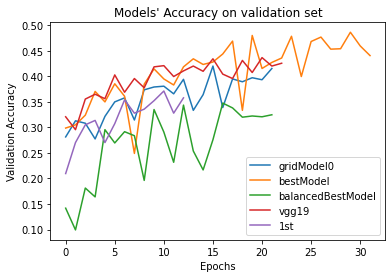

<Figure size 1440x1440 with 0 Axes>

In [ ]:
valAccCols = []
for c in combined_csv.columns:
  if 'val_accuracy' in c:
    valAccCols.append(c)
    
removeList = ['gridModel1_val_accuracy', 'gridModel2_val_accuracy', 'gridModel3_val_accuracy',]
valAccCols = [a for a in valAccCols if a not in removeList]

for c in valAccCols:
  plt.plot(range(32), combined_csv[c], label = c.split('_')[0])

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title("Models' Accuracy on validation set")
plt.legend()
plt.figure(figsize=(20, 20))
plt.show()

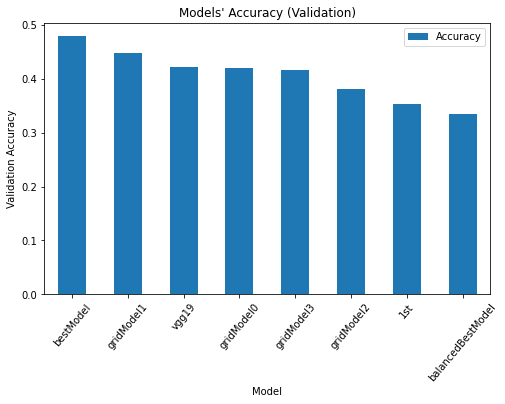

In [ ]:
modelsAcc = pd.DataFrame(columns=['Name', 'Accuracy'])
for c in range(len(combined_csv.columns)):
  if 'val_accuracy' in combined_csv.columns[c]:
    name = combined_csv.columns[c].split('_')[0]
    valAcc = combined_csv.iloc[combined_csv.iloc[:, c+1].idxmin(), c]
    modelsAcc = modelsAcc.append({'Name': name, 'Accuracy': valAcc}, ignore_index=True)
  
modelsAcc= modelsAcc.sort_values('Accuracy', ascending=False)
modelsAcc.plot(x="Name", y="Accuracy", kind="bar", rot=50, xlabel='Model', ylabel='Validation Accuracy', title="Models' Accuracy (Validation)", figsize=(8, 5))

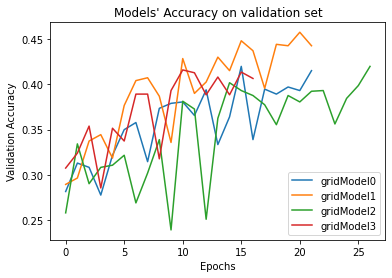

<Figure size 1440x1440 with 0 Axes>

In [ ]:
valAccCols = []
for c in combined_csv.columns:
  if 'gridModel' in c and 'val_accuracy' in c:
    valAccCols.append(c)

for c in valAccCols:
  plt.plot(range(32), combined_csv[c], label = c.split('_')[0])

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title("Models' Accuracy on validation set")
plt.legend()
plt.figure(figsize=(20, 20))
plt.show()

In [ ]:
gridModels = pd.read_csv(myDir+'/models/gridModelsConf.csv')

In [ ]:
gridModels

,Unnamed: 0,Name,neur,dropout
0,0,gridModel0,8,0.0
1,1,gridModel1,16,0.0
2,2,gridModel2,8,0.5
3,3,gridModel3,16,0.5
